In [1]:
import matplotlib.pyplot as plt

from glob import glob

import numpy as np
import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F

import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import optuna

import wandb

import pickle5 as pickle

from synth_ae import Encoder, Decoder

In [2]:
class SynthDataset(Dataset):
    def __init__(self):
        self.imgs_path = '/data/scratch/bariskurtkaya/synthetic_dataset/'
        self.data = []
        
        for img_path in glob(self.imgs_path + '/*.png'):
            if 'exo' in img_path:
                self.data.append([img_path, 'star_exo'])
            else:
                self.data.append([img_path, 'star_only'])
        
        print(self.data[0])
        self.class_map = {'star_only' : 0, 'star_exo': 1}
        self.img_dim = (28, 28)

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        img_path, class_name = self.data[idx]
        img = cv.imread(img_path, 0)
        
        #noise = np.random.normal(0,10,img.shape)
        #noisy_img = img + noise
                
        #img = cv.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        
        img_tensor = img_tensor.float()
        
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id


In [3]:
dataset = SynthDataset()
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

IndexError: list index out of range

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
with open("/data/scratch/bariskurtkaya/synthetic_dataset/125_enc.pickle", "rb") as fin:
    enc_best = pickle.load(fin)
    
with open("/data/scratch/bariskurtkaya/synthetic_dataset/125_dec.pickle", "rb") as fin:
    dec_best = pickle.load(fin)

In [6]:
enc_best = enc_best.to(device)

In [7]:
dec_best = dec_best.to(device)

In [8]:
enc_best, dec_best

(Encoder(
   (layer1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer2): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer3): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer4): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (layer5): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm2d(128,

In [47]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [48]:
test_epoch(enc_best, dec_best, device, train_loader, loss_fn = torch.nn.MSELoss())


torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256, 1000])
torch.Size([256,

tensor(801.1661)

In [49]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

enc_best.eval()
dec_best.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = enc_best(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(50, 128)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = dec_best(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:50],10,5))
    plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 1, 1, 28, 28]

In [36]:
img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/trial_exo1.png', 0)
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.float()
img_tensor = img_tensor.view((-1, 160, 160))
img_tensor.shape

torch.Size([1, 160, 160])

In [65]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    #targets = test_dataset.targets.numpy()
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        if i < n/2:
            img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/trial{np.random.randint(low=0, high=10000)}.png', 0)
        else:
            img = cv.imread(f'/data/scratch/bariskurtkaya/synthetic_dataset/trial_exo{np.random.randint(low=0, high=10000)}.png', 0)
        noise = np.random.normal(0,60,img.shape)
        img = img + noise
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.float()
        img_tensor = img_tensor.view((-1, 160, 160))
        img_tensor = img_tensor.to(device)
        
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img_tensor))
        plt.imshow(img_tensor.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

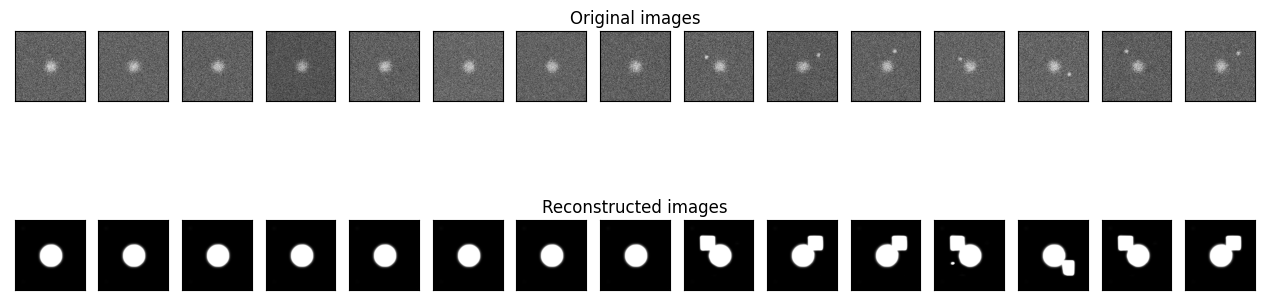

In [66]:
plot_ae_outputs(enc_best,dec_best,n=5)

In [22]:
import pandas as pd

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    enc_best.eval()
    with torch.no_grad():
        encoded_img  = enc_best(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

  0%|          | 0/10000 [00:00<?, ?it/s]

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -0.329695        -0.163019         0.184351         0.113479   
1            0.107827        -0.436170        -0.429107         0.307531   
2            0.127139         0.528341         0.215720         0.042645   
3            0.030685         0.140397         0.152833         0.710988   
4            0.094318        -0.161220         0.336812        -0.392374   
...               ...              ...              ...              ...   
9995         0.299010        -0.079865        -0.114750         0.219090   
9996         0.471212         0.449171        -0.150133         0.588933   
9997        -0.208361         0.121818        -0.075447        -0.259302   
9998        -0.025567         0.334340        -0.065935         0.035692   
9999         0.212000         0.406402         0.106968         0.829099   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0           -0.362167         0.063864         1.066069         0.094463   
1           -0.080048         0.228982        -0.305365         0.380400   
2            0.523097         0.328148         0.502382         0.181325   
3           -0.484581        -0.461320         0.423281        -0.427464   
4           -0.432561        -0.094247         0.404629         0.266940   
...               ...              ...              ...              ...   
9995        -0.727070         0.248843         1.310737         0.443906   
9996        -0.462926        -0.210233         0.674508        -0.717075   
9997        -0.018460        -0.247338         1.459353        -0.186589   
9998        -0.112593        -0.082101         0.272554         0.260474   
9999         0.886563        -0.354329         0.068569        -0.352195   

      Enc. Variable 8  Enc. Variable 9  ...  Enc. Variable 119  \
0           -0.173536        -1.704188  ...           0.025079   
1           -0.210297        -1.573430  ...          -0.030792   
2           -0.185897        -0.801595  ...          -0.406984   
3           -0.253577        -2.279301  ...           0.133993   
4            0.333194        -1.186864  ...           1.046629   
...               ...              ...  ...                ...   
9995         0.324255        -0.907687  ...           0.282371   
9996         0.309827        -1.403817  ...           0.062669   
9997        -0.168591        -1.689267  ...           0.083356   
9998        -0.593669        -2.258561  ...           0.006503   
9999        -0.235057        -1.261245  ...           0.209497   

      Enc. Variable 120  Enc. Variable 121  Enc. Variable 122  \
0              0.168045          -0.123641           2.835154   
1              0.035583          -0.376610           3.352913   
2              0.208790           0.045018           2.063385   
3              0.460109           0.167386           3.085369   
4              0.233117           0.094700           3.601102   
...                 ...                ...                ...   
9995           0.130554           0.549076           4.043217   
9996           0.065688           0.338707           3.518051   
9997           0.769278           0.152669           3.161937   
9998           0.204064          -0.420972           2.756157   
9999          -0.148111           0.914847           3.499104   

      Enc. Variable 123  Enc. Variable 124  Enc. Variable 125  \
0             -0.001331          -0.112758           0.288194   
1              0.699830           0.917905           0.018938   
2              0.052557           0.172222          -0.493487   
3              0.169035           1.439801          -0.467137   
4             -0.009747           0.529597          -0.250012   
...                 ...                ...                ...   
9995           0.560393           1.214499          -0.241102   
9996           0.052886           1.437879           0.430560   
9997          -0.5000

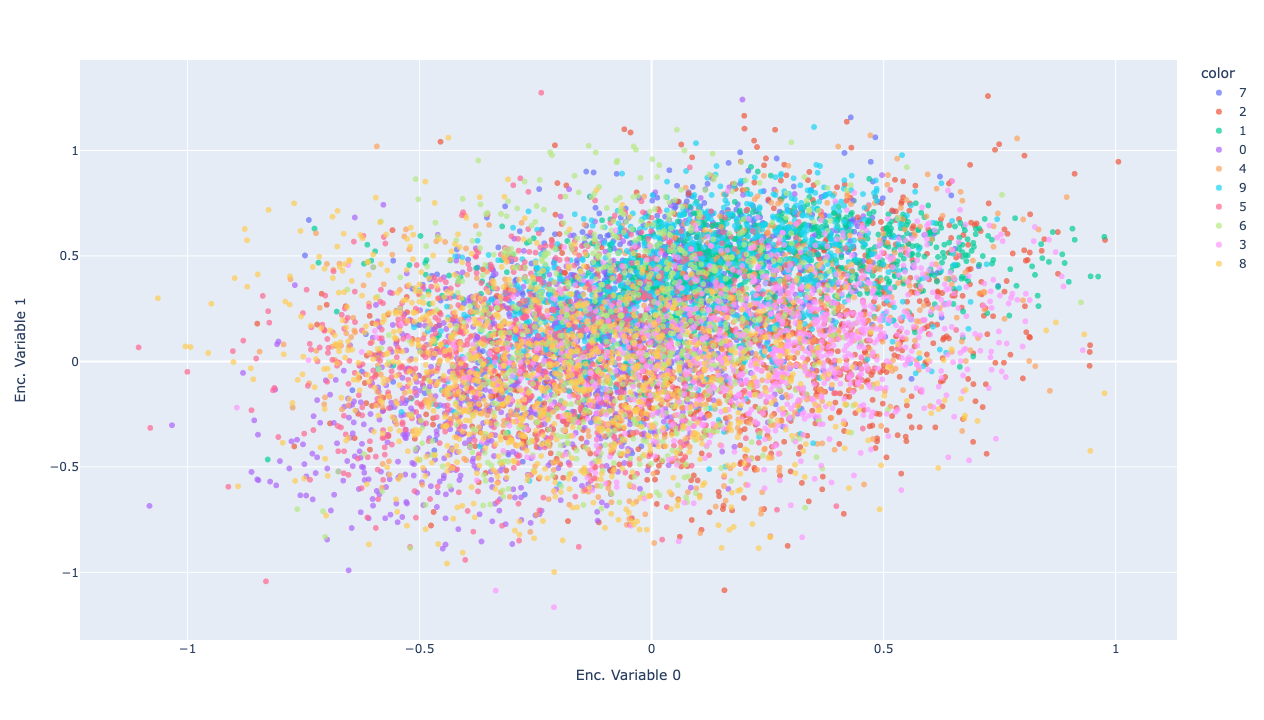

In [23]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

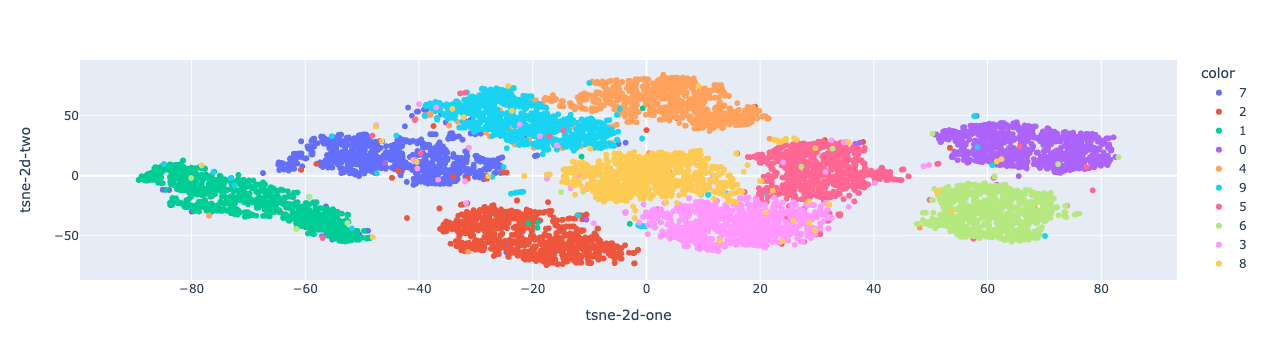

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()